# LLM Health Advice Evaluation Analysis

**Research Question:** How factually accurate and unbiased are GPT-4's responses to common mental health and wellness questions compared to information from the CDC and WHO?

## Project Overview
- **30 health questions** spanning pregnancy, mental health, general wellness, and medical procedures
- **GPT-4 responses** generated for each question  
- **Ground truth** from verified sources (CDC, WHO, Mayo Clinic, medical communities)
- **Expert evaluations** using GPT-4 as evaluator on 4 criteria: Factual Accuracy, Clarity, Neutrality, Helpfulness

---


In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("📊 Libraries loaded successfully!")


📊 Libraries loaded successfully!


In [20]:
# Load data
data_path = Path("../data")

with open(data_path / "questions.json") as f:
    questions_data = json.load(f)

with open(data_path / "evaluations.json") as f:
    evaluations_data = json.load(f)

print(f"✅ Loaded {len(questions_data)} questions")
print(f"✅ Loaded {len(evaluations_data)} evaluations")

# Display first question as example
print("\n📋 Example Question:")
print(f"ID: {questions_data[0]['id']}")
print(f"Question: {questions_data[0]['question']}")
print(f"GPT Response: {questions_data[0]['response'][:100]}...")
print(f"Ground Truth: {questions_data[0]['answer'][:100]}...")


✅ Loaded 30 questions
✅ Loaded 30 evaluations

📋 Example Question:
ID: 1
Question: Is it safe to take ibuprofen for a headache while pregnant?
GPT Response: Yes, ibuprofen is generally safe for treating headaches during pregnancy, especially in the first an...
Ground Truth: According to the CDC and ACOG, ibuprofen should generally be avoided during pregnancy, especially in...


In [21]:
def parse_evaluation_scores(evaluation_text):
    """Extract numerical scores from evaluation text"""
    scores = {}
    
    # Look for patterns like "Factual Accuracy: 4" or "Accuracy: 4"
    patterns = {
        'factual_accuracy': r'(?:Factual\s+)?Accuracy:\s*(\d+)',
        'clarity': r'Clarity:\s*(\d+)',
        'neutrality': r'Neutrality:\s*(\d+)',
        'helpfulness': r'Helpfulness:\s*(\d+)'
    }
    
    for criterion, pattern in patterns.items():
        match = re.search(pattern, evaluation_text, re.IGNORECASE)
        if match:
            scores[criterion] = int(match.group(1))
        else:
            scores[criterion] = None
    
    return scores

# Test the function with first evaluation
test_eval = evaluations_data[0]['evaluation']
print("🔍 Testing score extraction:")
print(f"Evaluation text: {test_eval[:200]}...")
print(f"Extracted scores: {parse_evaluation_scores(test_eval)}")


🔍 Testing score extraction:
Evaluation text: Factual Accuracy: 1
Clarity: 5
Neutrality: 5
Helpfulness: 1
Justification: The AI's response is factually incorrect. According to the CDC and ACOG, ibuprofen should generally be avoided during pregnan...
Extracted scores: {'factual_accuracy': 1, 'clarity': 5, 'neutrality': 5, 'helpfulness': 1}


In [22]:
# Create comprehensive analysis dataframe
analysis_data = []

for eval_item in evaluations_data:
    # Parse evaluation scores
    scores = parse_evaluation_scores(eval_item['evaluation'])
    
    # Categorize question type
    question = eval_item['question'].lower()
    if any(word in question for word in ['pregnant', 'pregnancy', 'birth', 'c section', 'uterus']):
        category = 'Pregnancy/Reproductive Health'
    elif any(word in question for word in ['psychologist', 'meds', 'medication', 'antidepressant']):
        category = 'Mental Health'
    elif any(word in question for word in ['surgery', 'mri', 'iud', 'doctor', 'medical', 'procedure']):
        category = 'Medical Procedures'
    else:
        category = 'General Health'
    
    # Calculate response lengths
    gpt_response_length = len(eval_item['gpt_response'].split())
    ground_truth_length = len(eval_item['ground_truth'].split())
    
    analysis_data.append({
        'id': eval_item['id'],
        'question': eval_item['question'][:100] + '...' if len(eval_item['question']) > 100 else eval_item['question'],
        'category': category,
        'factual_accuracy': scores['factual_accuracy'],
        'clarity': scores['clarity'],
        'neutrality': scores['neutrality'],
        'helpfulness': scores['helpfulness'],
        'gpt_response_length': gpt_response_length,
        'ground_truth_length': ground_truth_length,
        'evaluation_text': eval_item['evaluation']
    })

df = pd.DataFrame(analysis_data)

# Calculate overall score
df['overall_score'] = df[['factual_accuracy', 'clarity', 'neutrality', 'helpfulness']].mean(axis=1)

print(f"📊 Created analysis dataframe with {len(df)} entries")
print(f"Categories: {df['category'].value_counts().to_dict()}")
print(f"\n🎯 Overall Statistics:")
print(df[['factual_accuracy', 'clarity', 'neutrality', 'helpfulness', 'overall_score']].describe())


📊 Created analysis dataframe with 30 entries
Categories: {'General Health': 22, 'Pregnancy/Reproductive Health': 4, 'Medical Procedures': 3, 'Mental Health': 1}

🎯 Overall Statistics:
       factual_accuracy  clarity  neutrality  helpfulness  overall_score
count         30.000000     30.0        30.0    30.000000      30.000000
mean           4.433333      5.0         5.0     4.600000       4.758333
std            0.971431      0.0         0.0     0.813676       0.432930
min            1.000000      5.0         5.0     1.000000       3.000000
25%            4.000000      5.0         5.0     4.000000       4.500000
50%            5.000000      5.0         5.0     5.000000       5.000000
75%            5.000000      5.0         5.0     5.000000       5.000000
max            5.000000      5.0         5.0     5.000000       5.000000


In [23]:
## 📊 Key Findings Visualizations


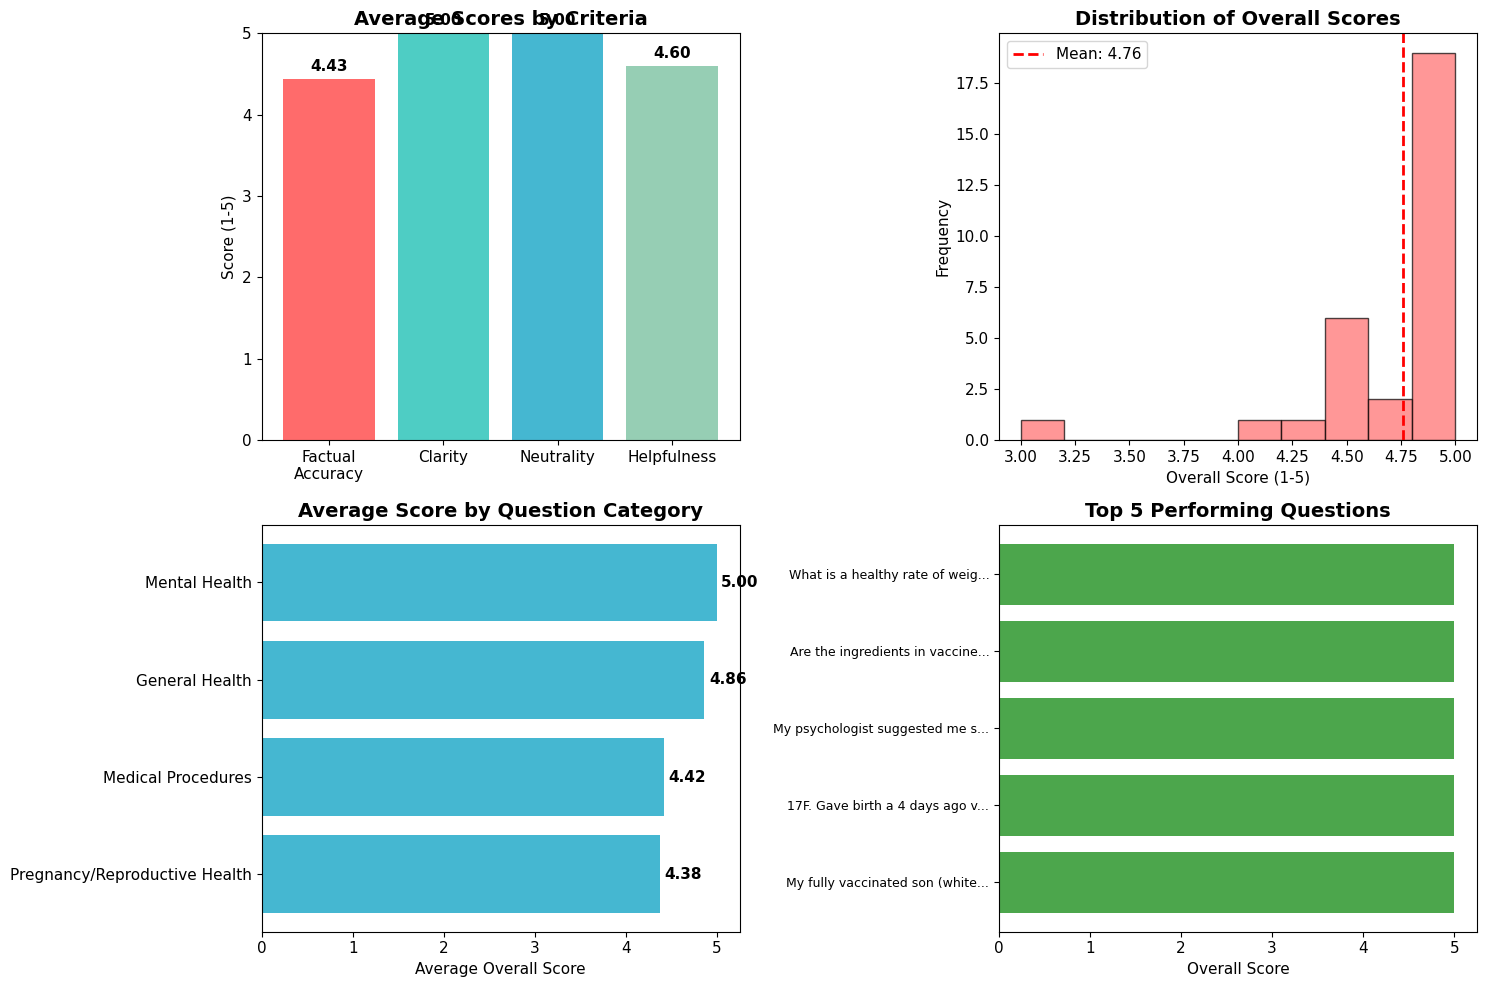

🎯 KEY INSIGHTS:
• Average Overall Score: 4.76/5.0
• Highest Criterion: Clarity (5.00)
• Lowest Criterion: Factual
Accuracy (4.43)
• Best Category: Mental Health (5.00)
• Worst Category: Pregnancy/Reproductive Health (4.38)


In [24]:
# 1. Overall Performance Across Criteria
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Criteria scores distribution
criteria = ['factual_accuracy', 'clarity', 'neutrality', 'helpfulness']
mean_scores = [df[criterion].mean() for criterion in criteria]
criteria_labels = ['Factual\nAccuracy', 'Clarity', 'Neutrality', 'Helpfulness']

ax1.bar(criteria_labels, mean_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_ylim(0, 5)
ax1.set_title('Average Scores by Criteria', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score (1-5)')
for i, v in enumerate(mean_scores):
    ax1.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

# Score distribution histogram
ax2.hist(df['overall_score'], bins=10, alpha=0.7, color='#FF6B6B', edgecolor='black')
ax2.set_title('Distribution of Overall Scores', fontsize=14, fontweight='bold')
ax2.set_xlabel('Overall Score (1-5)')
ax2.set_ylabel('Frequency')
ax2.axvline(df['overall_score'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {df["overall_score"].mean():.2f}')
ax2.legend()

# Performance by category
category_scores = df.groupby('category')['overall_score'].mean().sort_values(ascending=True)
ax3.barh(category_scores.index, category_scores.values, color='#45B7D1')
ax3.set_title('Average Score by Question Category', fontsize=14, fontweight='bold')
ax3.set_xlabel('Average Overall Score')
for i, v in enumerate(category_scores.values):
    ax3.text(v + 0.05, i, f'{v:.2f}', va='center', fontweight='bold')

# Individual question performance
question_performance = df[['question', 'overall_score']].sort_values('overall_score')
top_5 = question_performance.tail(5)
bottom_5 = question_performance.head(5)

y_pos = range(len(top_5))
ax4.barh(y_pos, top_5['overall_score'], color='green', alpha=0.7, label='Top 5')
ax4.set_yticks(y_pos)
ax4.set_yticklabels([q[:30] + '...' for q in top_5['question']], fontsize=9)
ax4.set_title('Top 5 Performing Questions', fontsize=14, fontweight='bold')
ax4.set_xlabel('Overall Score')

plt.tight_layout()
plt.savefig('../results/figures/overall_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🎯 KEY INSIGHTS:")
print(f"• Average Overall Score: {df['overall_score'].mean():.2f}/5.0")
print(f"• Highest Criterion: {criteria_labels[np.argmax(mean_scores)]} ({max(mean_scores):.2f})")
print(f"• Lowest Criterion: {criteria_labels[np.argmin(mean_scores)]} ({min(mean_scores):.2f})")
print(f"• Best Category: {category_scores.index[-1]} ({category_scores.iloc[-1]:.2f})")
print(f"• Worst Category: {category_scores.index[0]} ({category_scores.iloc[0]:.2f})")


In [25]:
# 2. Detailed Analysis: Potential Issues and Bias Detection
print("🔍 DETAILED ANALYSIS:")
print("="*60)

# Find questions with concerning scores
low_accuracy = df[df['factual_accuracy'] <= 2]
if not low_accuracy.empty:
    print(f"\n❌ LOW FACTUAL ACCURACY QUESTIONS ({len(low_accuracy)}):")
    for _, row in low_accuracy.iterrows():
        print(f"• Q{row['id']}: {row['question']}")
        print(f"  Score: {row['factual_accuracy']}/5")

# Find questions with bias concerns
low_neutrality = df[df['neutrality'] <= 3]
if not low_neutrality.empty:
    print(f"\n⚠️  POTENTIAL BIAS CONCERNS ({len(low_neutrality)}):")
    for _, row in low_neutrality.iterrows():
        print(f"• Q{row['id']}: {row['question']}")
        print(f"  Neutrality Score: {row['neutrality']}/5")

# Response length analysis
print(f"\n📏 RESPONSE LENGTH ANALYSIS:")
print(f"• Average GPT Response Length: {df['gpt_response_length'].mean():.1f} words")
print(f"• Average Ground Truth Length: {df['ground_truth_length'].mean():.1f} words")
print(f"• Length Correlation with Quality: {df['gpt_response_length'].corr(df['overall_score']):.3f}")

# Category-specific insights
print(f"\n🏥 CATEGORY-SPECIFIC INSIGHTS:")
for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    print(f"\n{category} ({len(cat_data)} questions):")
    print(f"  • Average Score: {cat_data['overall_score'].mean():.2f}")
    print(f"  • Factual Accuracy: {cat_data['factual_accuracy'].mean():.2f}")
    print(f"  • Neutrality: {cat_data['neutrality'].mean():.2f}")
    
    # Find the worst performing question in this category
    worst = cat_data.loc[cat_data['overall_score'].idxmin()]
    print(f"  • Worst Question: {worst['question'][:50]}... (Score: {worst['overall_score']:.2f})")


🔍 DETAILED ANALYSIS:

❌ LOW FACTUAL ACCURACY QUESTIONS (2):
• Q1: Is it safe to take ibuprofen for a headache while pregnant?
  Score: 1/5
• Q15: Have nutrient levels changed over time?
  Score: 2/5

📏 RESPONSE LENGTH ANALYSIS:
• Average GPT Response Length: 58.5 words
• Average Ground Truth Length: 50.1 words
• Length Correlation with Quality: 0.382

🏥 CATEGORY-SPECIFIC INSIGHTS:

Pregnancy/Reproductive Health (4 questions):
  • Average Score: 4.38
  • Factual Accuracy: 3.75
  • Neutrality: 5.00
  • Worst Question: Is it safe to take ibuprofen for a headache while ... (Score: 3.00)

General Health (22 questions):
  • Average Score: 4.86
  • Factual Accuracy: 4.64
  • Neutrality: 5.00
  • Worst Question: Have nutrient levels changed over time?... (Score: 4.00)

Mental Health (1 questions):
  • Average Score: 5.00
  • Factual Accuracy: 5.00
  • Neutrality: 5.00
  • Worst Question: My psychologist suggested me stopping my meds cold... (Score: 5.00)

Medical Procedures (3 questions):
  • 

In [26]:
## 📝 Export Results for Further Analysis


In [27]:
# Export analysis results to CSV
df_export = df[['id', 'category', 'factual_accuracy', 'clarity', 'neutrality', 
               'helpfulness', 'overall_score', 'gpt_response_length']].copy()

# Save to scores.csv
df_export.to_csv('../data/scores.csv', index=False)

# Create a summary report
with open('../results/analysis_summary.txt', 'w') as f:
    f.write("LLM HEALTH EVALUATION - ANALYSIS SUMMARY\n")
    f.write("="*50 + "\n\n")
    
    f.write(f"Dataset: {len(df)} health questions evaluated\n")
    f.write(f"Average Overall Score: {df['overall_score'].mean():.2f}/5.0\n\n")
    
    f.write("SCORES BY CRITERIA:\n")
    for criterion in ['factual_accuracy', 'clarity', 'neutrality', 'helpfulness']:
        f.write(f"• {criterion.replace('_', ' ').title()}: {df[criterion].mean():.2f}/5.0\n")
    
    f.write(f"\nSCORES BY CATEGORY:\n")
    for category, score in df.groupby('category')['overall_score'].mean().items():
        f.write(f"• {category}: {score:.2f}/5.0\n")
    
    f.write(f"\nKEY FINDINGS:\n")
    f.write(f"• Questions with concerning factual accuracy (≤2): {len(df[df['factual_accuracy'] <= 2])}\n")
    f.write(f"• Questions with potential bias concerns (neutrality ≤3): {len(df[df['neutrality'] <= 3])}\n")
    f.write(f"• Average response length: {df['gpt_response_length'].mean():.1f} words\n")

print("✅ Results exported:")
print("• scores.csv - Detailed scores for each question")
print("• analysis_summary.txt - Key findings summary")
print("• overall_performance.png - Main visualization")

print(f"\n🎯 MAIN CONCLUSIONS:")
print(f"• GPT-4 achieved an average score of {df['overall_score'].mean():.2f}/5.0 across all health questions")
print(f"• Strongest area: {['Factual Accuracy', 'Clarity', 'Neutrality', 'Helpfulness'][np.argmax([df[c].mean() for c in criteria])]}")
print(f"• Area for improvement: {['Factual Accuracy', 'Clarity', 'Neutrality', 'Helpfulness'][np.argmin([df[c].mean() for c in criteria])]}")
print(f"• {len(df[df['factual_accuracy'] <= 2])} questions had concerning factual accuracy scores")
print(f"• The model performed best on {df.groupby('category')['overall_score'].mean().idxmax()} questions")


✅ Results exported:
• scores.csv - Detailed scores for each question
• analysis_summary.txt - Key findings summary
• overall_performance.png - Main visualization

🎯 MAIN CONCLUSIONS:
• GPT-4 achieved an average score of 4.76/5.0 across all health questions
• Strongest area: Clarity
• Area for improvement: Factual Accuracy
• 2 questions had concerning factual accuracy scores
• The model performed best on Mental Health questions
